# Synthetic Flood Data Generation

**Objective:** The primary goal of this notebook is to generate synthetic flood water extent data for Addis Ababa and Kampala from 2005-2014. This extends the available observational data (2015-2025) to create a complete 20-year time series, enabling more robust long-term analysis and modeling.

**Methodology:**
The process uses the statistical properties of the real data as a blueprint for the synthetic data:

1.  **Pattern Extraction:** Analyze the real data (2015-2025) to extract its underlying trend, seasonal patterns, and residual noise.
2.  **Data Synthesis** Generate the 2005-2014 data by extrapolating the trend backward and combining it with the extracted seasonality and simulated noise.
3.  **Validation** Merge the synthetic and real datasets and visualize the complete time series to ensure a seamless and realistic transition.

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Load and Prepare Data

In [ ]:
# Load the real data
url = "https://raw.githubusercontent.com/MIT-Emerging-Talent/ET6-CDSP-group-01-repo/refs/heads/main/1_datasets/raw_data/Monthly_Flood_Water_Extent_Kampala_Addis_2015_2025_km2.csv"
df_real = pd.read_csv(url)
df_real = df_real.drop(columns=["system:index", "source", ".geo"])

In [ ]:
# Convert month column to datetime
df_real["month"] = pd.to_datetime(df_real["month"])

# Sort by city and month
df_real = df_real.sort_values(["city", "month"]).reset_index(drop=True)

print(f"Real data loaded: {len(df_real)} records")
print(f"Date range: {df_real['month'].min()} to {df_real['month'].max()}")
print(f"Cities: {df_real['city'].unique()}")

Real data loaded: 250 records
Date range: 2015-01-01 00:00:00 to 2025-06-01 00:00:00
Cities: ['Addis Ababa' 'Kampala']


# Analyze Real Data - Time Series Decomposition


To understand the underlying patterns in the flood data, we perform a time series decomposition for each city. This separates the data into three components:
- **Trend:** The long-term progression of the series.
- **Seasonality:** The repeating short-term cycle in the series.
- **Residual:** The random, irregular noise remaining after removing the trend and seasonality.

We use an **additive model**, which assumes that `Value = Trend + Seasonality + Residual`. This is a suitable choice when the seasonal fluctuations are roughly constant over time.

In [ ]:
def analyze_city_data(city_data, city_name):
    """Analyze time series data for a specific city"""

    print(f"\n--- Analysis for {city_name} ---")

    # Create time series with monthly frequency
    ts_data = city_data.set_index("month")["flood_water_extent (km^2)"]
    ts_data = ts_data.asfreq("MS")  # Month start frequency

    # Handle missing values if any
    if ts_data.isnull().any():
        print(
            f"Warning: Found {ts_data.isnull().sum()} missing values. Forward filling..."
        )
        ts_data = ts_data.fillna(method="ffill")

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts_data, model="additive", period=12)

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Calculate statistics
    stats_dict = {
        "mean": ts_data.mean(),
        "std": ts_data.std(),
        "min": ts_data.min(),
        "max": ts_data.max(),
        "trend_slope": None,
        "seasonal_pattern": seasonal.groupby(seasonal.index.month).mean(),
        "residual_std": residual.std(),
        "residual_mean": residual.mean(),
    }

    # Calculate trend slope (linear regression)
    x = np.arange(len(trend.dropna()))
    y = trend.dropna().values
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        stats_dict["trend_slope"] = slope
        print(f"Trend slope: {slope:.4f} km²/month (R²: {r_value**2:.3f})")

    print(f"Mean flood extent: {stats_dict['mean']:.2f} km²")
    print(f"Standard deviation: {stats_dict['std']:.2f} km²")
    print(f"Range: {stats_dict['min']:.2f} - {stats_dict['max']:.2f} km²")
    print(f"Residual std: {stats_dict['residual_std']:.4f} km²")

    return stats_dict, decomposition


# Analyze each city separately
city_analyses = {}
decompositions = {}

for city in df_real["city"].unique():
    city_data = df_real[df_real["city"] == city].copy()
    stats_dict, decomp = analyze_city_data(city_data, city)
    city_analyses[city] = stats_dict
    decompositions[city] = decomp


--- Analysis for Addis Ababa ---
Trend slope: -0.5292 km²/month (R²: 0.542)
Mean flood extent: 90.52 km²
Standard deviation: 82.17 km²
Range: 7.86 - 440.31 km²
Residual std: 44.3530 km²

--- Analysis for Kampala ---
Trend slope: -0.3997 km²/month (R²: 0.268)
Mean flood extent: 174.61 km²
Standard deviation: 47.06 km²
Range: 23.04 - 213.44 km²
Residual std: 32.6611 km²


# Generate Synthetic Data (2005-2014)



Since real data is only available from 2015, we generate synthetic data for the preceding 10 years (2005-2014). This creates a longer, more complete dataset for analysis.

The synthetic data is generated based on the patterns derived from the real data:
- **Trend:** The trend is linearly extrapolated backward from the first known trend value in January 2015.
- **Seasonality:** The average seasonal pattern observed in the 2015-2025 data is applied.
- **Noise:** Random noise is generated from a normal distribution with the same mean and standard deviation as the residuals from the decomposition.

The final synthetic value is the sum of these three components, ensuring it cannot be negative.

In [ ]:
def generate_synthetic_data(
    city_name, analysis_dict, start_date="2005-01", end_date="2014-12"
):
    """Generate synthetic flood data for a city based on analyzed patterns"""

    print(f"\nGenerating synthetic data for {city_name}...")

    # Create date range for synthetic data
    date_range = pd.date_range(start=start_date, end=end_date, freq="MS")

    synthetic_data = []

    # Get the last known trend value (from 2015-01)
    months_back = len(date_range)

    for i, date in enumerate(date_range):
        # Calculate trend component (extrapolate backward)
        months_from_2015 = months_back - i
        if analysis_dict["trend_slope"] is not None:
            # Extrapolate trend backward from 2015 baseline
            baseline_2015 = analysis_dict["mean"]  # Use mean as baseline
            trend_component = baseline_2015 - (
                analysis_dict["trend_slope"] * months_from_2015
            )
        else:
            trend_component = analysis_dict["mean"]

        # Get seasonal component for this month
        month_num = date.month
        seasonal_component = analysis_dict["seasonal_pattern"][month_num]

        # Generate noise component
        noise_component = np.random.normal(
            analysis_dict["residual_mean"], analysis_dict["residual_std"]
        )

        # Combine components
        synthetic_value = trend_component + seasonal_component + noise_component

        # Ensure non-negative values
        synthetic_value = max(0, synthetic_value)

        synthetic_data.append(
            {
                "city": city_name,
                "month": date.strftime("%Y-%m"),
                "flood_water_extent (km^2)": synthetic_value,
                "is_synthetic": True,
            }
        )

    print(f"Generated {len(synthetic_data)} synthetic records for {city_name}")
    return pd.DataFrame(synthetic_data)


# Generate synthetic data for both cities
synthetic_dfs = []

for city in df_real["city"].unique():
    synthetic_df = generate_synthetic_data(city, city_analyses[city])
    synthetic_dfs.append(synthetic_df)

# Combine all synthetic data
df_synthetic = pd.concat(synthetic_dfs, ignore_index=True)

print(f"\nTotal synthetic records generated: {len(df_synthetic)}")


Generating synthetic data for Addis Ababa...
Generated 120 synthetic records for Addis Ababa

Generating synthetic data for Kampala...
Generated 120 synthetic records for Kampala

Total synthetic records generated: 240


# Combine Real and Synthetic Data

Here, we merge the original (real) and newly generated (synthetic) data into a single, comprehensive DataFrame. An `is_synthetic` boolean flag is used to clearly distinguish between the two data sources. The final dataset is sorted chronologically for each city.

In [ ]:
# Prepare real data with is_synthetic flag
df_real_formatted = df_real.copy()
df_real_formatted["month"] = df_real_formatted["month"].dt.strftime("%Y-%m")
df_real_formatted["is_synthetic"] = False

# Combine datasets
df_combined = pd.concat([df_synthetic, df_real_formatted], ignore_index=True)

# Sort by city and month
df_combined["month_sort"] = pd.to_datetime(df_combined["month"])
df_combined = df_combined.sort_values(["city", "month_sort"]).reset_index(drop=True)
df_combined = df_combined.drop("month_sort", axis=1)

# Reorder columns as specified
df_final = df_combined[["city", "month", "flood_water_extent (km^2)", "is_synthetic"]]

print("Final combined dataset:")
print(f"Total records: {len(df_final)}")
print(f"Synthetic records: {len(df_final[df_final['is_synthetic']])}")
print(f"Real records: {len(df_final[~df_final['is_synthetic']])}")
print(f"Date range: {df_final['month'].min()} to {df_final['month'].max()}")

Final combined dataset:
Total records: 490
Synthetic records: 240
Real records: 250
Date range: 2005-01 to 2025-06


In [ ]:
df_final.head()

,city,month,flood_water_extent (km^2),is_synthetic
0,Addis Ababa,2005-01,288.827774,True
1,Addis Ababa,2005-02,252.539333,True
2,Addis Ababa,2005-03,242.303970,True
3,Addis Ababa,2005-04,207.319781,True
4,Addis Ababa,2005-05,120.322212,True


# Visualize the Combined Time Series

To visually inspect the results, we plot the synthetic and real data on the same time axis for each city. This helps confirm that the synthetic data provides a plausible lead-in to the real data and that the overall patterns are consistent. A vertical line marks the boundary between the two datasets.

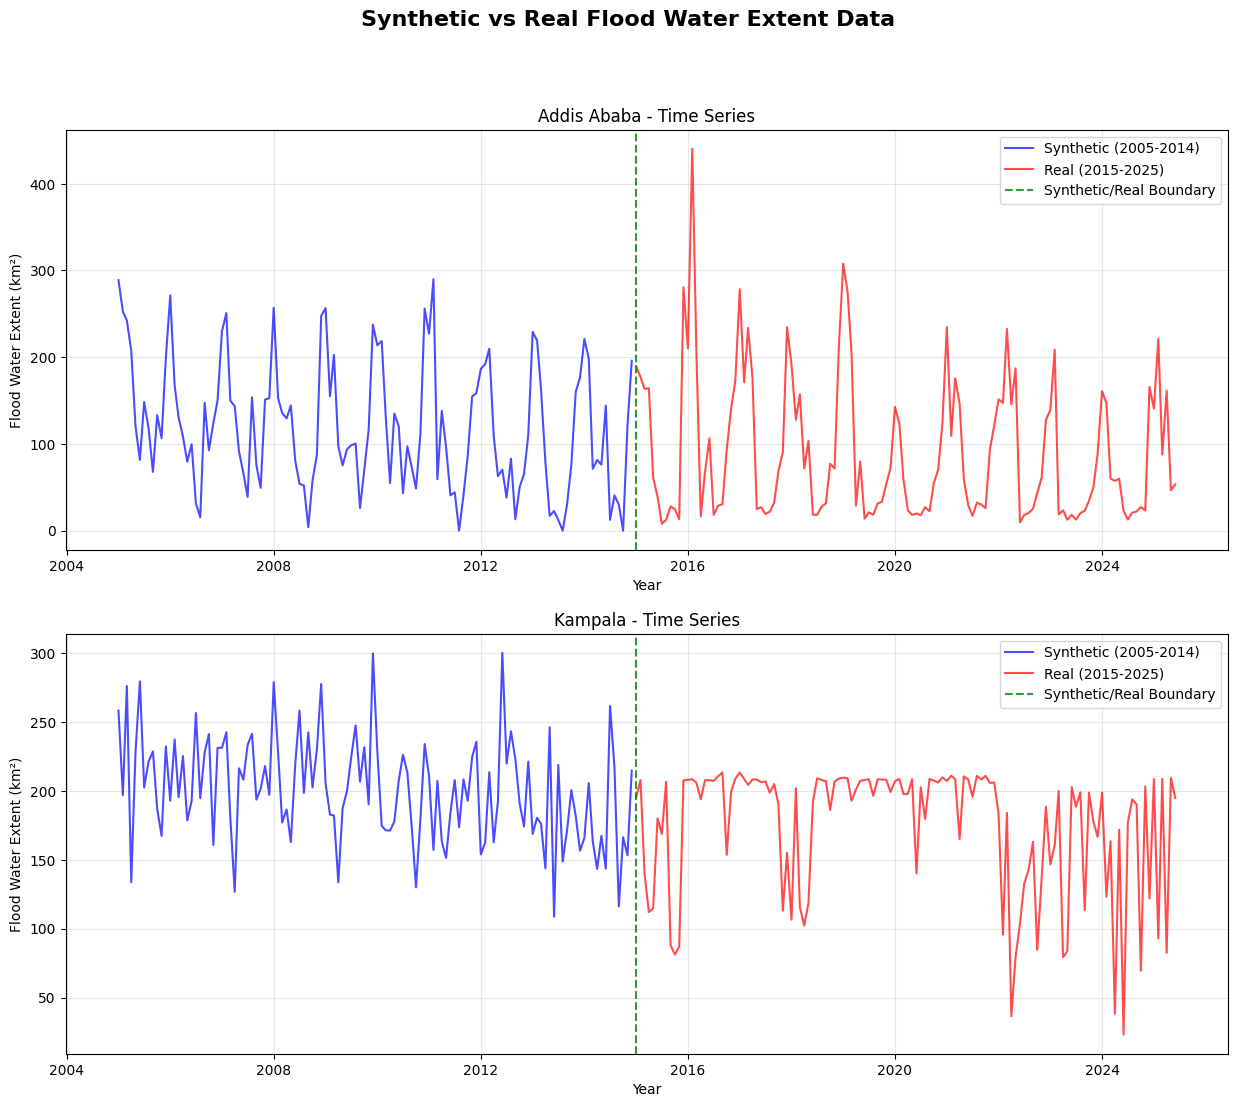

In [ ]:
fig, axes = plt.subplots(2, figsize=(15, 12))
fig.suptitle(
    "Synthetic vs Real Flood Water Extent Data", fontsize=16, fontweight="bold"
)

cities = df_final["city"].unique()

for i, city in enumerate(cities):
    city_data = df_final[df_final["city"] == city].copy()
    city_data["month_dt"] = pd.to_datetime(city_data["month"])

    # Time series plot
    ax1 = axes[i]
    synthetic_mask = city_data["is_synthetic"]
    real_mask = ~city_data["is_synthetic"]

    ax1.plot(
        city_data[synthetic_mask]["month_dt"],
        city_data[synthetic_mask]["flood_water_extent (km^2)"],
        color="blue",
        alpha=0.7,
        label="Synthetic (2005-2014)",
    )
    ax1.plot(
        city_data[real_mask]["month_dt"],
        city_data[real_mask]["flood_water_extent (km^2)"],
        color="red",
        alpha=0.7,
        label="Real (2015-2025)",
    )

    ax1.axvline(
        pd.to_datetime("2015-01"),
        color="green",
        linestyle="--",
        alpha=0.8,
        label="Synthetic/Real Boundary",
    )
    ax1.set_title(f"{city} - Time Series")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Flood Water Extent (km²)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

# Annual Flood Aggregation

To compare long-term changes between the cities, we aggregate the monthly flood extent data into a total annual sum. This smooths out the monthly seasonality and makes it easier to observe year-over-year trends across the entire 20-year period.

In [ ]:
# Filter the DataFrame for 'Kampala' and 'Addis Ababa'
df_yearly = df_final[df_final["city"].isin(["Kampala", "Addis Ababa"])].copy()

# Ensure 'month' is datetime type for year extraction
df_yearly["month"] = pd.to_datetime(df_yearly["month"])

# Extract year from the 'month' column
df_yearly["year"] = df_yearly["month"].dt.year

# Group by city, year, and the 'is_synthetic' flag, and sum the flood extent
df_yearly = (
    df_yearly.groupby(["city", "year", "is_synthetic"])["flood_water_extent (km^2)"]
    .sum()
    .reset_index()
)

# Rename the column for clarity
df_yearly.rename(
    columns={"flood_water_extent (km^2)": "Total Flood Extent (km^2)"},
    inplace=True,
)

In [ ]:
df_yearly.head()

,city,year,is_synthetic,Total Flood Extent (km^2)
0,Addis Ababa,2005,True,1966.254434
1,Addis Ababa,2006,True,1417.851332
2,Addis Ababa,2007,True,1553.415543
3,Addis Ababa,2008,True,1403.095318
4,Addis Ababa,2009,True,1529.397062


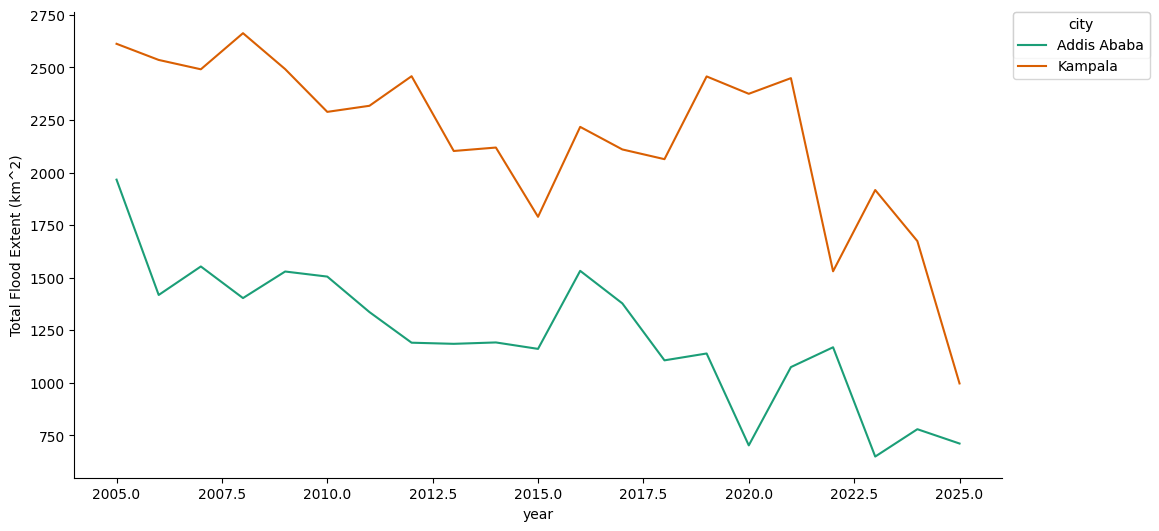

In [ ]:
from matplotlib import pyplot as plt


def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette("Dark2"))
    xs = series["year"]
    ys = series["Total Flood Extent (km^2)"]

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])


fig, ax = plt.subplots(figsize=(10, 5.2), layout="constrained")
df_sorted = df_yearly.sort_values("year", ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby("city")):
    _plot_series(series, series_name, i)
    fig.legend(title="city", bbox_to_anchor=(1, 1), loc="upper left")
sns.despine(fig=fig, ax=ax)
plt.xlabel("year")
_ = plt.ylabel("Total Flood Extent (km^2)")

# Export Final Dataset

The final aggregated yearly dataset is exported to a CSV file for reporting or further analysis.

In [ ]:
# Export to CSV
output_filename_yearly = "combined_flood_data_2005_2025_yearly_total.csv"
df_yearly.to_csv(output_filename_yearly, index=False)
print(f"Final yearly dataset exported to: {output_filename_yearly}")

Final yearly dataset exported to: combined_flood_data_2005_2025_yearly_total.csv
